In [1]:
topology_file = '../out/sim/sequence_length1000/lsd-tree.date.newick'
trace_file = '../out/sim/sequence_length1000/beast-relaxed-fixed.log'
tree_file = '../out/sim/sequence_length1000/beast-relaxed-fixed.trees'
beast_config_file = '../config/beast-config.yaml'
plot_out_file = '../out/sim/sequence_length1000/rate-correlations.png'
variational_fit_file = '../out/sim/sequence_length1000/variational-relaxed-scaled.pickle'
prior_params_file = '../config/prior-params.yaml'
clock_approx = 'scaled'

In [2]:
import pandas as pd
from treeflow_pipeline.util import yaml_input

renaming = {
    "TreeHeight": 'tree_height',
    "popSize": "pop_size", 
    "clockRate": "clock_rate",
    "Tree.treeLength": "tree_length"
}


beast_config = yaml_input(beast_config_file)
burn_in = beast_config['burn_in']

def remove_burn_in(x):
    return x[np.arange(len(x)) > int(len(trace) * burn_in)]

trace = (pd.read_table(trace_file, comment="#")
         .pipe(lambda x: x[list(renaming.keys())])
         .pipe(lambda x: x.rename(columns=renaming))
        )
trace

,tree_height,pop_size,clock_rate,tree_length
0,11.598780,6.826043,0.025718,35.305584
1,11.990203,7.566664,0.025499,37.669636
2,11.803198,7.675428,0.022381,37.212079
3,12.764976,5.988233,0.023360,39.417927
4,12.663104,6.224484,0.023989,38.307972
...,...,...,...,...
9996,13.525518,8.328248,0.019642,44.074692
9997,13.073807,7.378375,0.021423,42.340711
9998,13.098275,6.162758,0.019576,43.222760
9999,12.142354,6.779927,0.020802,39.792133


In [3]:
import dendropy

trees = dendropy.TreeList.get(path=tree_file, schema="nexus", rooting="default-rooted")

In [4]:
import numpy as np

def traverse_leaves_first(tree, f, out=None):
    taxon_count = len(tree.taxon_namespace)
    if out is None:
        out = np.zeros(2 * taxon_count - 1)
    leaf_index = 0
    node_index = taxon_count
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            out[leaf_index] = f(node)
            leaf_index += 1
        else:
            out[node_index] = f(node)
            node_index += 1
    return out

taxon_count = len(trees[0].taxon_namespace)
blens = np.zeros((len(trees), 2 * taxon_count - 1))
rates = np.zeros((len(trees), 2 * taxon_count - 1))

for i, tree in enumerate(trees):
    traverse_leaves_first(tree, lambda x: x.edge.length, out=blens[i])
    traverse_leaves_first(tree, lambda x: float(x.annotations['rate'].value), out=rates[i])

blens[-3:], rates[-3:]

(array([[2.45992816e+00, 4.60026438e-01, 9.81936760e-01, 1.63396203e-01,
         2.21230769e-02, 5.52665356e+00, 5.50851107e+00, 4.03532880e+00,
         1.25423974e+00, 6.25192614e+00, 3.61020892e+00, 3.01300349e+00,
         2.10014242e+00, 2.36385617e+00, 4.43118509e+00, 1.04029394e+00,
         0.00000000e+00],
        [2.58670595e+00, 5.86804228e-01, 5.37829883e-01, 1.44729510e-01,
         3.45638437e-03, 5.08077048e+00, 5.06262799e+00, 4.09611116e+00,
         1.31502210e+00, 5.16922697e+00, 3.18476873e+00, 2.87058214e+00,
         2.33486574e+00, 2.09191404e+00, 4.05581663e+00, 6.70900783e-01,
         0.00000000e+00],
        [2.52765043e+00, 5.27748701e-01, 1.08978530e+00, 1.44232482e-01,
         2.95935575e-03, 4.96700165e+00, 4.94885916e+00, 4.17650130e+00,
         1.39541224e+00, 5.26390403e+00, 3.73722118e+00, 2.73265702e+00,
         1.95748722e+00, 1.52037654e+00, 4.96099429e+00, 2.92492019e-01,
         0.00000000e+00]]),
 array([[0.02145716, 0.01815777, 0.01571464,

In [5]:
rates_scaled = rates / trace.clock_rate[:, np.newaxis]
mean_rate_b = remove_burn_in(trace.clock_rate)
rates_b = remove_burn_in(rates)[:, :-1]
rates_scaled_b = remove_burn_in(rates_scaled)[:, :-1]
blens_b = remove_burn_in(blens)[:, :-1]

In [6]:
distances = blens_b * rates_b
mean_distances = np.mean(distances, axis=0)
mean_distances

array([0.0470572 , 0.00661407, 0.01864587, 0.00353978, 0.00074796,
       0.12418338, 0.08168119, 0.0917426 , 0.02015122, 0.12895116,
       0.07232765, 0.0638233 , 0.05129037, 0.04181868, 0.12170393,
       0.01890971])

In [8]:
from treeflow_pipeline.util import pickle_input
variational_fit = pickle_input(variational_fit_file)

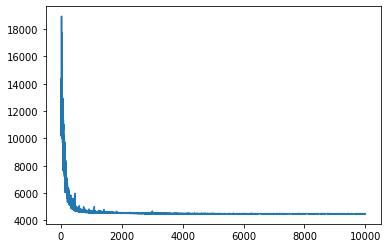

In [9]:
import matplotlib.pyplot as plt
plt.plot(variational_fit['loss'])

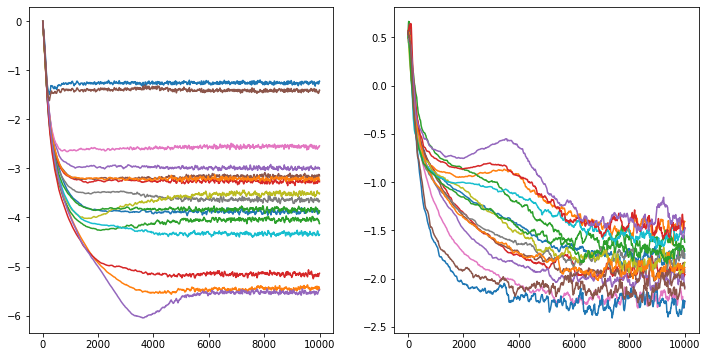

In [10]:
rate_var_traces = variational_fit['params'][-2:] # TODO: How can we make sure we get the right variables?
fig, axs = plt.subplots(ncols=len(rate_var_traces), figsize=(12, 6))
for ax, trace in zip(axs, rate_var_traces):
    ax.plot(trace)

In [11]:
import treeflow_pipeline.model
from importlib import reload
reload(treeflow_pipeline.model)

approx = treeflow_pipeline.model.reconstruct_approx(topology_file, variational_fit, yaml_input(prior_params_file), 'relaxed', clock_approx)

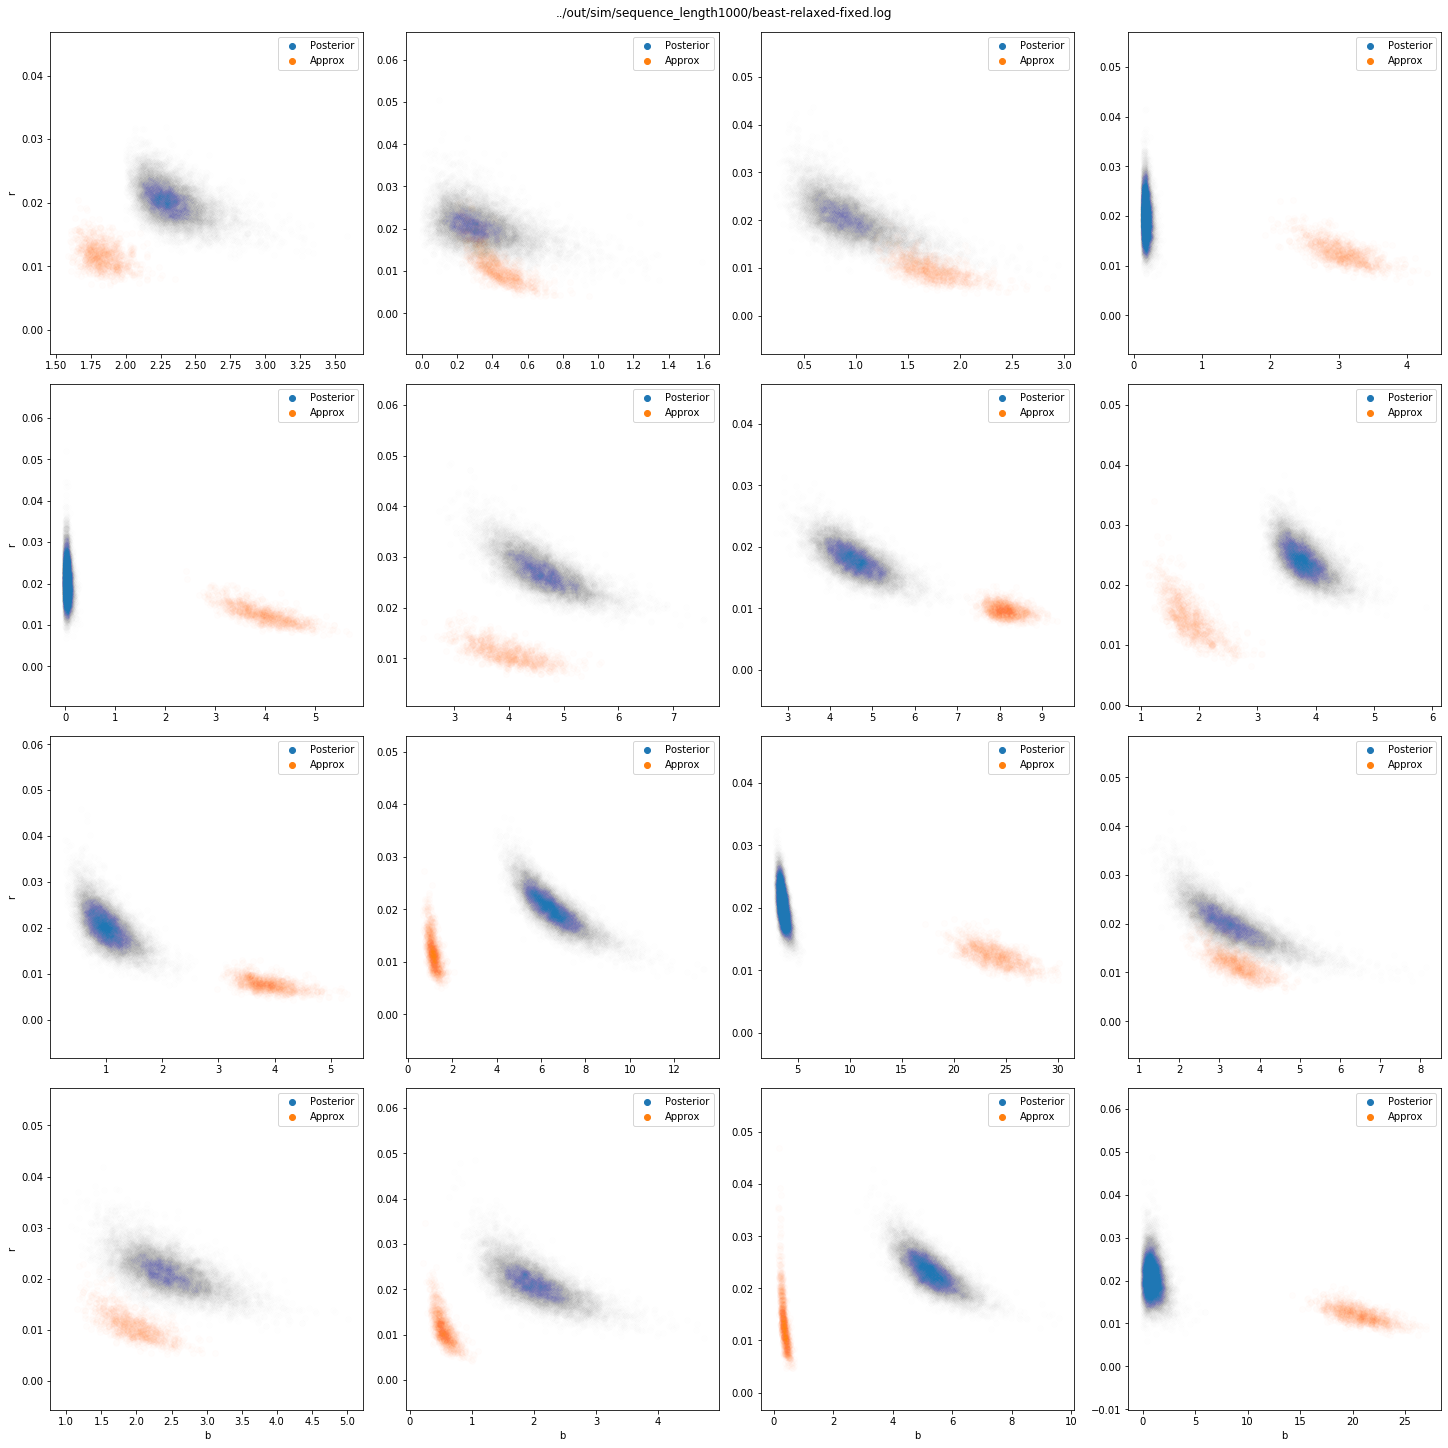

In [52]:
import treeflow.sequences

n_cols = 4
n_branches = 2*taxon_count - 2
n_rows = n_branches // n_cols

def plot_approximation(approx):
    approx_samples = approx.sample(1000)
    approx_blens = treeflow.sequences.get_branch_lengths(approx_samples['tree'])
    approx_rates_t = approx_samples['clock_rate'].numpy() * approx_samples['rates'].numpy().T
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows), constrained_layout=True)
    axs_flat = [ax for row in axs for ax in row]
    for ax, branch_blens, branch_rates, approx_blens, approx_rates in zip(axs_flat, blens_b.T, rates_b.T, approx_blens.numpy().T, approx_rates_t):
        ax.scatter(branch_blens, branch_rates, alpha=0.005, label='Posterior')
        ax.scatter(approx_blens, approx_rates, alpha=0.01, label='Approx')
        leg = ax.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)

    for ax in axs[-1]:
        ax.set_xlabel('b')

    for row in axs:
        row[0].set_ylabel('r')
        
    plt.suptitle(trace_file);


plot_approximation(approx)
plt.savefig(plot_out_file)

In [70]:
blens[0]

array([2.00686928, 0.00696756, 0.55071916, 0.26035753, 0.1190844 ,
       4.15781   , 4.13966751, 3.56946897, 0.78837991, 5.20549   ,
       3.08203   , 2.50599   , 2.11105   , 1.47178   , 4.85089   ,
       0.47903   , 0.        ])

In [71]:
init_node_heights

<tf.Tensor: shape=(8,), dtype=float64, numpy=
array([ 5.88572307,  7.26766271,  4.78537593,  8.56417408, 10.04706206,
       10.20281523, 10.2029182 , 38.3787664 ])>

In [67]:
import tensorflow as tf
init_node_heights = approx.model['tree'].height_distribution.node_height_distribution.bijector.forward(variational_fit['params'][-4][0])
init_heights = tf.concat([approx.model['tree'].height_distribution.leaf_heights, init_node_heights], 0)
treeflow.sequences.get_branch_lengths(dict(heights=init_heights, topology=approx.model['tree'].model['topology'].sample()))

<tf.Tensor: shape=(16,), dtype=float64, numpy=
array([1.87700307e+00, 4.73053071e-01, 1.99626271e+00, 4.17775408e+00,
       4.76723593e+00, 4.78537593e+00, 8.81945206e+00, 2.13977523e+00,
       3.81659820e+00, 1.38193964e+00, 3.11111037e+01, 3.77879815e+00,
       1.48288798e+00, 1.55753166e-01, 1.02973029e-04, 2.81758482e+01])>